# Linear regression and Baysian linear regression on LED

In [1]:
!pip install pyro-ppl


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [4]:
data = pd.read_csv("../Data/Data_processed.csv",delimiter=";")
data.head(10)

,Country,continent,Life expectancy,Year,Status,infant deaths,Alcohol,Hepatitis B,MeaslesPrMillion,OverweightOfAdults%,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,Schooling,WaterFacility,WomenInParlament
0,Afghanistan,Asia,62.659,2015,0,53.0,0.000,64.0,7.051856,22.3,6.0,8.16,65.0,0.1,6.372055,17.334595,17.2,10.1,61.339781,27.710843
1,Afghanistan,Asia,62.545,2014,0,55.0,0.010,62.0,6.200509,21.7,58.0,8.18,62.0,0.1,6.419501,17.303381,17.5,10.0,58.659374,27.710843
2,Afghanistan,Asia,62.417,2013,0,57.2,0.010,64.0,6.066108,21.1,62.0,8.13,64.0,0.1,6.450067,17.266806,17.7,9.9,56.014043,27.710843
3,Afghanistan,Asia,61.923,2012,0,59.4,0.010,67.0,7.933080,20.5,67.0,8.52,67.0,0.1,6.508708,17.232138,17.9,9.8,53.403517,27.710843
4,Afghanistan,Asia,61.419,2011,0,61.8,0.010,68.0,8.011023,19.9,68.0,7.87,68.0,0.1,4.167242,17.191361,18.2,9.5,50.827846,27.710843
5,Afghanistan,Asia,60.851,2010,0,64.2,0.020,66.0,7.595890,19.3,66.0,9.20,66.0,0.1,6.317758,17.154466,18.4,9.2,48.287084,27.710843
6,Afghanistan,Asia,60.364,2009,0,66.8,0.010,63.0,7.959276,18.8,63.0,9.42,63.0,0.1,6.102320,17.125517,18.6,8.9,45.781609,27.309237
7,Afghanistan,Asia,59.852,2008,0,69.3,0.028,64.0,7.377759,18.2,64.0,8.33,64.0,0.1,5.925221,17.089904,18.8,8.7,43.311145,27.685950
8,Afghanistan,Asia,59.111,2007,0,72.0,0.018,63.0,7.040536,17.7,63.0,6.73,63.0,0.1,5.915759,17.069881,19.0,8.4,40.875746,27.685950
9,Afghanistan,Asia,58.684,2006,0,74.7,0.026,63.0,5.298317,17.1,58.0,7.43,58.0,0.1,5.611535,17.051949,19.2,8.1,38.475460,27.309237


array([[<Axes: title={'center': 'Life expectancy '}>,
        <Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Status'}>,
        <Axes: title={'center': 'infant deaths'}>],
       [<Axes: title={'center': 'Alcohol'}>,
        <Axes: title={'center': 'Hepatitis B'}>,
        <Axes: title={'center': 'MeaslesPrMillion'}>,
        <Axes: title={'center': 'OverweightOfAdults%'}>],
       [<Axes: title={'center': 'Polio'}>,
        <Axes: title={'center': 'Total expenditure'}>,
        <Axes: title={'center': 'Diphtheria '}>,
        <Axes: title={'center': ' HIV/AIDS'}>],
       [<Axes: title={'center': 'GDP'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': ' thinness  1-19 years'}>,
        <Axes: title={'center': 'Schooling'}>],
       [<Axes: title={'center': 'WaterFacility'}>,
        <Axes: title={'center': 'WomenInParlament'}>, <Axes: >, <Axes: >]],
      dtype=object)

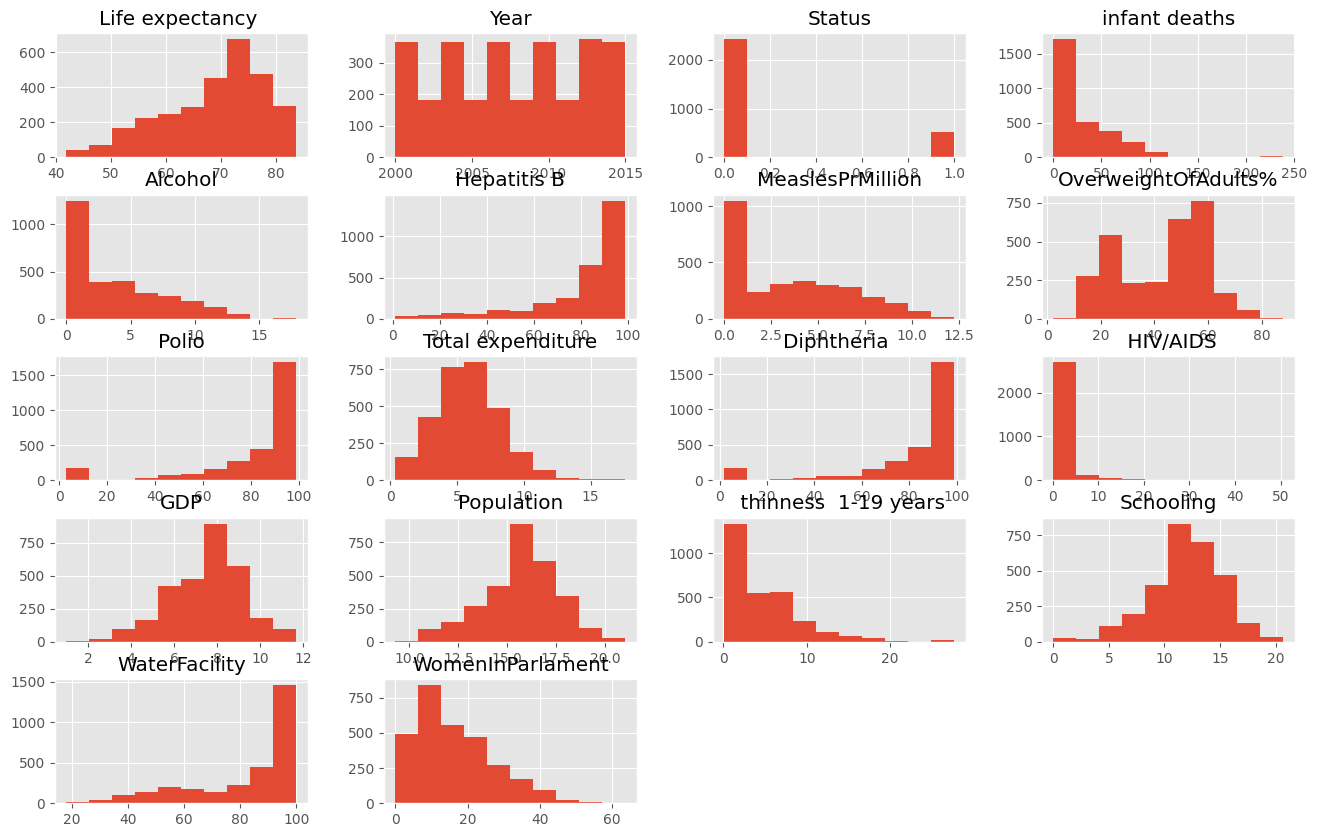

In [5]:
data.hist()

In [103]:
mat = data.values

features = data.columns.to_list()[5:]
X_numpy = np.array(mat[:,5:],float) #These are the regressors
print(X_numpy.shape)

y_numpy = np.array(mat[:,2],float) #This is the target variable life expectancy
print(y_numpy.shape)


# standardize input features
X_mean = X_numpy.mean(axis=0)
X_std = X_numpy.std(axis=0)
X = (X_numpy - X_mean) / X_std

# standardize target
y_mean = y_numpy.mean()
y_std = y_numpy.std()
y = (y_numpy - y_mean) / y_std

(2936, 15)
(2936,)
(2936,)


In [104]:
# Split data into traning, test and validation
training_idx = (data['Year'] >= 2000) & (data['Year'] <= 2011)
test_idx = (data['Year'] >= 2012) & (data['Year'] <= 2013)
val_idx = (data['Year'] >= 2014) & (data['Year'] <= 2015)

X_train = X[training_idx,:]
X_test = X[test_idx,:]
X_val = X[val_idx, :]

y_train = y[training_idx]
y_test = y[test_idx]
y_val = y[val_idx]

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))
print("num val: %d" % len(y_val))

num train: 2196
num test: 374
num val: 366


In [13]:
from sklearn import datasets, linear_model

regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(X_train, y_train)
preds_lr = regr.predict(X_test)
print(regr.coef_)
print(features)

[-0.31015835 -0.00757893  0.00713931  0.04070885  0.06580159  0.01559203
  0.02577214  0.01565512 -0.31162119  0.08038926  0.03539164 -0.0226253
  0.15335403  0.25961925  0.04154044]
['infant deaths', 'Alcohol', 'Hepatitis B', 'MeaslesPrMillion', 'OverweightOfAdults%', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', 'Schooling', 'WaterFacility', 'WomenInParlament']


In [92]:
def compute_error(trues, predicted):
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    return rmse

In [17]:
y_hat_train = regr.predict(X_train)
y_hat_test = regr.predict(X_test)
y_hat_val = regr.predict(X_val)


# Convert back to the original scale
preds_train = y_hat_train * y_std + y_mean
preds_test = y_hat_test * y_std + y_mean
preds_val = y_hat_val * y_std + y_mean
y_true_train = y_train * y_std + y_mean
y_true_test = y_test * y_std + y_mean
y_true_val = y_val * y_std + y_mean


rmse_train = compute_error(y_true_train, preds_train)
rmse_test = compute_error(y_true_test, preds_test)
rmse_val = compute_error(y_true_val, preds_val)
print("RMSE train: %.3f\nRMSE test: %.3f\nRMSE val: %.3f\n" % (rmse_train,rmse_test,rmse_val))

RMSE train: 3.097
RMSE test: 3.435
RMSE val: 3.345



## Baysian regression

In [18]:
def model(X, obs=None):
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(1.0))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(X.matmul(beta), sigma), obs=obs)
        
    return y

In [50]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

In [51]:
# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [52]:
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 5122.4
[100] ELBO: 3823.4
[200] ELBO: 3046.9
[300] ELBO: 2618.4
[400] ELBO: 2256.2
[500] ELBO: 2281.8
[600] ELBO: 1705.0
[700] ELBO: 1702.0
[800] ELBO: 1495.8
[900] ELBO: 1268.0
[1000] ELBO: 1422.7
[1100] ELBO: 1082.3
[1200] ELBO: 1357.5
[1300] ELBO: 1246.5
[1400] ELBO: 1104.9
[1500] ELBO: 1211.2
[1600] ELBO: 1202.8
[1700] ELBO: 1058.5
[1800] ELBO: 1046.4
[1900] ELBO: 864.0
[2000] ELBO: 909.8
[2100] ELBO: 868.1
[2200] ELBO: 906.5
[2300] ELBO: 912.2
[2400] ELBO: 973.3
[2500] ELBO: 877.5
[2600] ELBO: 931.8
[2700] ELBO: 877.7
[2800] ELBO: 846.6
[2900] ELBO: 947.3
[3000] ELBO: 869.5
[3100] ELBO: 811.6
[3200] ELBO: 827.8
[3300] ELBO: 806.9
[3400] ELBO: 843.6
[3500] ELBO: 845.1
[3600] ELBO: 837.9
[3700] ELBO: 864.5
[3800] ELBO: 830.9
[3900] ELBO: 840.5


In [53]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [54]:
beta_samples = samples["beta"].detach().numpy()

In [55]:
# Compute predictions
y_hat_train2 =  np.mean(np.dot(X_train, beta_samples[:,0].T), axis=1)
y_hat_test2 = np.mean(np.dot(X_test, beta_samples[:,0].T), axis=1)
y_hat_val2 = np.mean(np.dot(X_val, beta_samples[:,0].T), axis=1)

In [56]:
preds_train2 = y_hat_train2 * y_std + y_mean
preds_test2 = y_hat_test2 * y_std + y_mean
preds_val2 = y_hat_val2 * y_std + y_mean

rmse_train2 = compute_error(y_true_train, preds_train2)
rmse_test2 = compute_error(y_true_test, preds_test2)
rmse_val2 = compute_error(y_true_val, preds_val2)
print("RMSE train: %.3f\nRMSE test: %.3f\nRMSE val: %.3f\n" % (rmse_train2,rmse_test2,rmse_val2))

RMSE train: 3.101
RMSE test: 3.432
RMSE val: 3.330



## Neural network

In [208]:
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

class Net(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(Net, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, X_nn, y=None):
        X_nn = self.relu(self.in_layer(X_nn))
        X_nn = self.relu(self.h_layer(X_nn))
        X_nn = self.relu(self.h_layer2(X_nn))
        X_nn = self.out_layer(X_nn)

        prediction_mean = X_nn.squeeze(-1)
        with pyro.plate("observations"):
            y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
            
        return y

In [209]:
# Define guide function
model = Net(n_in=X_train.shape[1], n_hidden=32, n_out=1)
guide = AutoDiagonalNormal(model)
pyro.clear_param_store()

In [210]:
# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 3312055.5
[500] ELBO: 137991.9
[1000] ELBO: 87712.7
[1500] ELBO: 68462.8
[2000] ELBO: 45405.7
[2500] ELBO: 43577.7
[3000] ELBO: 47632.4
[3500] ELBO: 41375.7
[4000] ELBO: 39014.0
[4500] ELBO: 28349.8
[5000] ELBO: 34906.3
[5500] ELBO: 24891.6
[6000] ELBO: 23212.2
[6500] ELBO: 28311.1
[7000] ELBO: 23526.8
[7500] ELBO: 26353.5
[8000] ELBO: 20862.5
[8500] ELBO: 21014.0
[9000] ELBO: 24161.4
[9500] ELBO: 18739.2
[10000] ELBO: 17486.5
[10500] ELBO: 18375.4
[11000] ELBO: 17352.8
[11500] ELBO: 15575.4
[12000] ELBO: 14371.4
[12500] ELBO: 13491.6
[13000] ELBO: 12980.1
[13500] ELBO: 11898.9
[14000] ELBO: 11009.2
[14500] ELBO: 11259.7
[15000] ELBO: 9309.8
[15500] ELBO: 8717.2
[16000] ELBO: 8045.2
[16500] ELBO: 7394.8
[17000] ELBO: 6550.8
[17500] ELBO: 6445.5
[18000] ELBO: 5862.2
[18500] ELBO: 5363.0
[19000] ELBO: 5246.7
[19500] ELBO: 5160.3


In [211]:
def compute_rmse(preds_train,preds_test,preds_val):
    # Convert back to the original scale
    y_true_train = y_train * y_std + y_mean
    y_true_test = y_test * y_std + y_mean
    y_true_val = y_val * y_std + y_mean
    def rmse(predicted,trues):
        rmse = np.sqrt(np.mean((predicted - trues)**2))
        return rmse
    rmse_train = rmse(y_true_train, preds_train)
    rmse_test = rmse(y_true_test, preds_test)
    rmse_val = rmse(y_true_val, preds_val)
    print("RMSE train: %.3f\nRMSE test: %.3f\nRMSE val: %.3f\n" % (rmse_train,rmse_test,rmse_val))
    return rmse_train, rmse_test, rmse_val

In [212]:
# Prepare test data for Pyro
X_test_torch = torch.tensor(X_test).float()
X_val_torch = torch.tensor(X_val).float()

from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples_test = predictive(X_test_torch)
samples_train = predictive(X_train_torch)
samples_val = predictive(X_val_torch)

y_pred_train = samples_train["obs"].mean(axis=0).detach().numpy() * y_std + y_mean
y_pred_test = samples_test["obs"].mean(axis=0).detach().numpy() * y_std + y_mean
y_pred_val = samples_val["obs"].mean(axis=0).detach().numpy() * y_std + y_mean


rmse_train3, rmse_test3, rmse_val3 = compute_rmse(y_pred_train,y_pred_test,y_pred_val)

RMSE train: 0.939
RMSE test: 2.044
RMSE val: 2.326



## Neural network + Lin reg

In [106]:
features

['infant deaths',
 'Alcohol',
 'Hepatitis B',
 'MeaslesPrMillion',
 'OverweightOfAdults%',
 'Polio',
 'Total expenditure',
 'Diphtheria ',
 ' HIV/AIDS',
 'GDP',
 'Population',
 ' thinness  1-19 years',
 'Schooling',
 'WaterFacility',
 'WomenInParlament']

In [235]:
class FFNet(PyroModule):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNet, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, X, y=None):
        lin_features = [2,3,5,7,8]
        non_lin_features = [i for i in range(15) if not i in(lin_features)]
        X_nn = X[:,non_lin_features]
        X_nn = self.relu(self.in_layer(X_nn))
        X_nn = self.relu(self.h_layer(X_nn))
        X_nn = self.relu(self.h_layer2(X_nn))
        X_nn = self.out_layer(X_nn)
        nn_out = X_nn.squeeze(-1)
        
        beta_lin = pyro.sample("beta", dist.Normal(torch.zeros(len(lin_features)), 
                                            torch.ones(len(lin_features))).to_event(1))
        X_linear = X[:,lin_features]
        with pyro.plate("observations"):
            linear_out = X_linear*beta_lin
            out = nn_out+torch.mean(linear_out)
            y = pyro.sample("obs", dist.Normal(out, 0.1), obs=y)
            
        return y

In [236]:
lin_features = [2,3,5,7,8]
non_lin_features = [i for i in range(15) if not i in(lin_features)]

# Define guide function
model = FFNet(n_in=len(non_lin_features), n_hidden=32, n_out=1)
guide = AutoDiagonalNormal(model)
pyro.clear_param_store()

In [237]:
# Define the number of optimization steps
n_steps = 25000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1155116.5
[500] ELBO: 56440.5
[1000] ELBO: 52954.2
[1500] ELBO: 39415.9
[2000] ELBO: 29156.7
[2500] ELBO: 22906.3
[3000] ELBO: 34316.9
[3500] ELBO: 19296.4
[4000] ELBO: 20928.8
[4500] ELBO: 15587.3
[5000] ELBO: 12897.8
[5500] ELBO: 13898.5
[6000] ELBO: 13487.7
[6500] ELBO: 11483.5
[7000] ELBO: 9401.9
[7500] ELBO: 12105.8
[8000] ELBO: 11600.0
[8500] ELBO: 8258.2
[9000] ELBO: 7919.5
[9500] ELBO: 7631.6
[10000] ELBO: 6637.6
[10500] ELBO: 8155.0
[11000] ELBO: 5718.8
[11500] ELBO: 5381.8
[12000] ELBO: 4797.6
[12500] ELBO: 3998.0
[13000] ELBO: 4217.5
[13500] ELBO: 3966.5
[14000] ELBO: 3318.6
[14500] ELBO: 3540.6
[15000] ELBO: 2943.8
[15500] ELBO: 2714.0
[16000] ELBO: 2950.9
[16500] ELBO: 2847.0
[17000] ELBO: 2363.4
[17500] ELBO: 2639.6
[18000] ELBO: 2205.0
[18500] ELBO: 2235.9
[19000] ELBO: 2358.9
[19500] ELBO: 1967.6
[20000] ELBO: 2048.6
[20500] ELBO: 2010.2
[21000] ELBO: 1649.8
[21500] ELBO: 1576.7
[22000] ELBO: 1537.7
[22500] ELBO: 1495.2
[23000] ELBO: 1469.0
[23500] ELBO: 1354.

In [238]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples_test = predictive(X_test_torch)
samples_train = predictive(X_train_torch)
samples_val = predictive(X_val_torch)

y_pred_train = samples_train["obs"].mean(axis=0).detach().numpy() * y_std + y_mean
y_pred_test = samples_test["obs"].mean(axis=0).detach().numpy() * y_std + y_mean
y_pred_val = samples_val["obs"].mean(axis=0).detach().numpy() * y_std + y_mean


rmse_train4, rmse_test4, rmse_val4 = compute_rmse(y_pred_train,y_pred_test,y_pred_val)

RMSE train: 0.701
RMSE test: 2.160
RMSE val: 2.515



In [240]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X_train_torch, y_train_torch)

In [241]:
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])


Estimated beta: [-0.19189991 -0.3646225   0.0012903  -0.23885402 -0.23945871]


In [242]:
regr.coef_[lin_features]

array([ 0.00713931,  0.04070885,  0.01559203,  0.01565512, -0.31162119])

In [245]:
np.array(features)[lin_features]

array(['Hepatitis B', 'MeaslesPrMillion', 'Polio', 'Diphtheria ',
       ' HIV/AIDS'], dtype='<U21')

array([[<Axes: title={'center': 'Life expectancy '}>,
        <Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Status'}>,
        <Axes: title={'center': 'infant deaths'}>],
       [<Axes: title={'center': 'Alcohol'}>,
        <Axes: title={'center': 'Hepatitis B'}>,
        <Axes: title={'center': 'MeaslesPrMillion'}>,
        <Axes: title={'center': 'OverweightOfAdults%'}>],
       [<Axes: title={'center': 'Polio'}>,
        <Axes: title={'center': 'Total expenditure'}>,
        <Axes: title={'center': 'Diphtheria '}>,
        <Axes: title={'center': ' HIV/AIDS'}>],
       [<Axes: title={'center': 'GDP'}>,
        <Axes: title={'center': 'Population'}>,
        <Axes: title={'center': ' thinness  1-19 years'}>,
        <Axes: title={'center': 'Schooling'}>],
       [<Axes: title={'center': 'WaterFacility'}>,
        <Axes: title={'center': 'WomenInParlament'}>, <Axes: >, <Axes: >]],
      dtype=object)

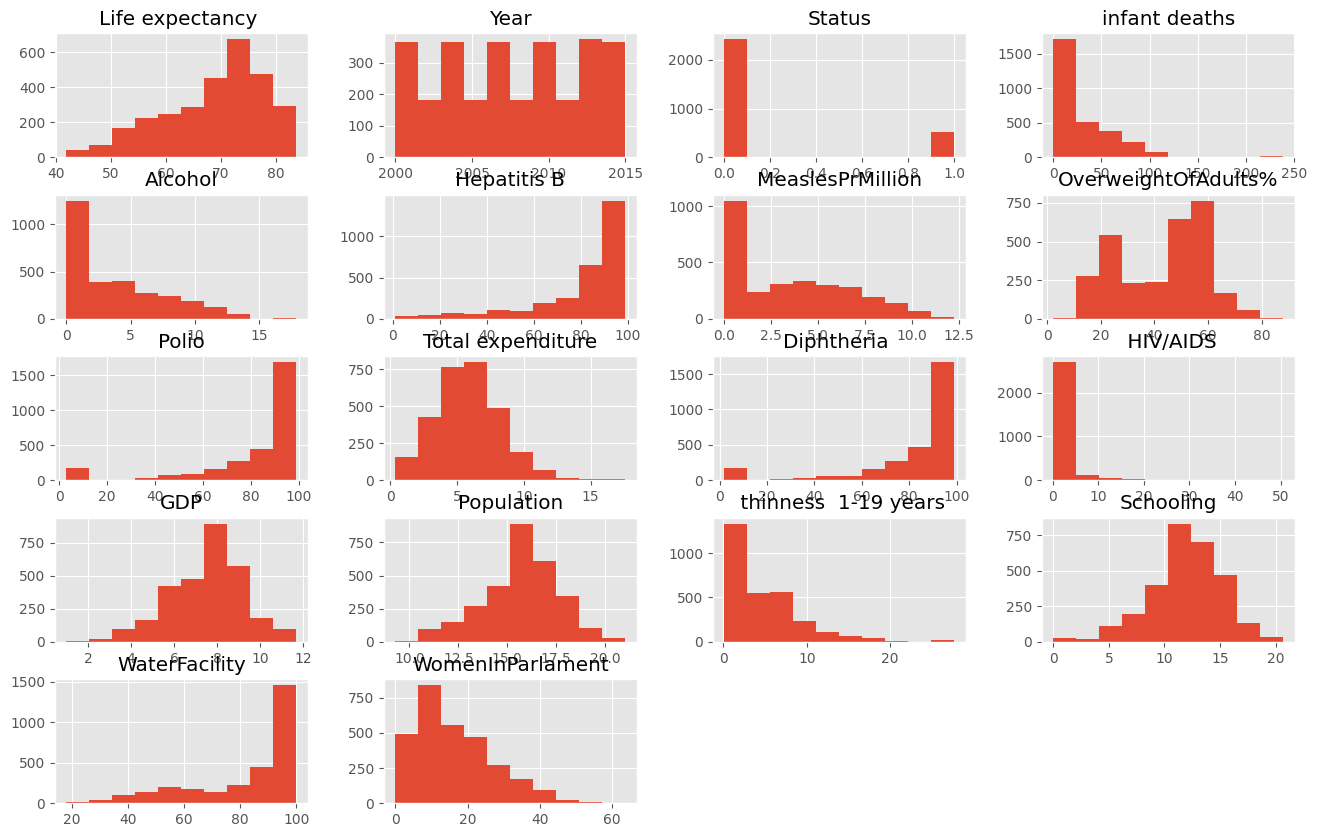

In [247]:
data.hist()